# Over-Representation Analysis

Notebook for performing an over-representation analysis on the top and bottom strains, in terms of redness and normalized redness.

2020-02-26

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


## 1. Load data

We will use:
* 4 lists (generated manually):
  * Top 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Top 500 genes in terms of normalized redness, with size $\geq$ 260.
  * Bottom 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Bottom 500 genes in terms of normalized redness, with size $\geq$ 180 and count > 1.
* The lookup table connecting positions in the 384-well plate to gene ids, as it has all GO-terms associated to each gene ID.

In [2]:
import pandas as pd

data = pd.read_csv(join(INTERMEDIATE,"top_and_bottom_500.csv"))
print(data)

    top_redness top_norm_redness bottom_redness bottom_norm_redness
0          CSE2             GAS5          IBA57                OPY1
1          MLC2             YOR1           OPY1                RIM8
2          YOR1          YJL175W        YCR090C               IBA57
3          NTA1             SKY1           HTD2                BUD8
4       YOL153C          YIL096C           DIA3               RPL9A
..          ...              ...            ...                 ...
495        PTK1             TRP1          SPO74                RTC2
496     YBR287W          YPR071W        YDL211C                IPK1
497        PLB2             BPT1           YCH1             YMR160W
498        TRP1             NEJ1           YSP2                STP2
499     YKR070W             REX3        YIL012W             YGL152C

[500 rows x 4 columns]


In [3]:
gene_ids = pd.read_csv(join(RAW_EXTERNAL,"geneIDs.txt"), sep="\t")
gene_ids = gene_ids[gene_ids["Gene"] != "Blank"]  # filter out blank data
gene_ids = gene_ids.drop(columns=["Plate #", "Row", "Column", "96-position"])  # remove unused columns
gene_ids.index = range(0,len(gene_ids.index))  # re-index for consistency later on
print(gene_ids)

            ORF       Gene                                         Decription  \
0       YLL040C      VPS13  Protein of unknown function; heterooligomeric ...   
1       YAL068C       PAU8  Protein of unknown function, member of the ser...   
2       YAL067C       SEO1  Putative permease, member of the allantoate tr...   
3       YLL041C       SDH2  Iron-sulfur protein subunit of succinate dehyd...   
4       YAL066W    YAL066W  Dubious open reading frame unlikely to encode ...   
...         ...        ...                                                ...   
4842    YER122C       GLO3  ADP-ribosylation factor GTPase activating prot...   
4843    YJL075C      APQ13  Dubious open reading frame, unlikely to encode...   
4844    YBR035C       PDX3  Pyridoxine (pyridoxamine) phosphate oxidase, h...   
4845    YPR072W       NOT5  Subunit of the CCR4-NOT complex, which is a gl...   
4846  YOR008C-A  YOR008C-A  Putative protein of unknown function, includes...   

                           

## 2. GO terms

We will first collect all GO terms in a single list, to be able to iterate through later.

In [4]:
GOterms = []
for (idx, row) in gene_ids.iterrows():
    row["GO Biological Process"] = row["GO Biological Process"].split(", ")
    GOterms.extend(row["GO Biological Process"])
GOterms = list(set(GOterms))
GOterms.sort()
print(GOterms)
GOterms.remove('-')

['-', 'DNA metabolic process', 'RNA metabolic process', 'biological_process', 'cell budding', 'cell cycle', 'cellular amino acid and derivative metabolic process', 'cellular aromatic compound metabolic process', 'cellular carbohydrate metabolic process', 'cellular component morphogenesis', 'cellular homeostasis', 'cellular lipid metabolic process', 'cellular membrane organization', 'cellular protein catabolic process', 'cellular respiration', 'chromosome organization', 'chromosome segregation', 'cofactor metabolic process', 'conjugation', 'cytokinesis', 'cytoskeleton organization', 'fungal-type cell wall organization', 'generation of precursor metabolites and energy', 'heterocycle metabolic process', 'meiosis', 'mitochondrion organization', 'nucleus organization', 'other', 'peroxisome organization', 'protein complex biogenesis', 'protein folding', 'protein modification process', 'pseudohyphal growth', 'response to chemical stimulus', 'response to stress', 'ribosome biogenesis', 'signal

## 3. Over-Representation Analysis

We need a function for the over-representation analysis. For each GO term the Fisher matrix is constructed as:

|   | Selected in group | Not selected |
|:-:|:-----------------:|:------------:|
| With GO term | F[0][0] | F[0][1] |
| Without GO term | F[1][0] | F[1][1] |

And then the alternative hypothesis is that there is a higher percentage of genes in the selected group with the GO term Vs without the GO term.

In [5]:
from fisher import pvalue

# over-representation function:
def over_rep(data, group_name, gene_ids, GOterms):
    pvalues = pd.DataFrame()
    group = list(data[group_name])
    for GOterm in GOterms:
        F = [[0, 0], [0, 0]]
        for (idx, row) in gene_ids.iterrows():
            i = 0 if GOterm in row["GO Biological Process"] else 1
            j = 0 if row["Gene"] in group else 1
            F[i][j] += 1
        pval = pvalue(F[0][0], F[0][1], F[1][0], F[1][1]).right_tail
        new_row = pd.DataFrame(data={"genes.selected":F[0][0], "genes.total":F[0][0] + F[0][1], "p.value": pval}, index=[GOterm])
        pvalues = pvalues.append(new_row)
    print(pvalues[pvalues["p.value"] < 0.05])
    return pvalues

Now we can call the function for all 4 groups:

In [6]:
p_values_top_redness = over_rep(data, "top_redness", gene_ids, GOterms)

Empty DataFrame
Columns: [genes.selected, genes.total, p.value]
Index: []


In [7]:
p_values_top_norm_redness = over_rep(data, "top_norm_redness", gene_ids, GOterms)

                    genes.selected  genes.total   p.value
biological_process             173         1405  0.004948


In [8]:
p_values_bottom_redness = over_rep(data, "bottom_redness", gene_ids, GOterms)

                              genes.selected  genes.total   p.value
protein modification process              56          410  0.026396


In [9]:
p_values_bottom_norm_redness = over_rep(data, "bottom_norm_redness", gene_ids, GOterms)

                           genes.selected  genes.total   p.value
vitamin metabolic process               9           46  0.049671


Results don't look very promising... most likely because there are not many GO terms included in the original file.

## 4. Using GOATOOLS

Let's try using more GO terms, via GOATOOLS. For that, we first need Entrez IDs for all genes both from the total list of _S. cerevisiae_ genes and from the 4 selected groups. We can get them using the `mygene` package ([Wu et al. 2014](https://www.biorxiv.org/content/10.1101/009332v1)), querying the original ORFs:

In [10]:
import mygene
mg = mygene.MyGeneInfo()
geneORFs = list(gene_ids["ORF"])
entrezIDs = mg.querymany(geneORFs, scopes='locus_tag', fields='entrezgene', species=559292)  # S. cerevisiae S288C
entrezIDs[:10]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4847...done.
Finished.
45 input query terms found dup hits:
	[('YML086C', 2), ('YMR169C', 2), ('YMR174C', 2), ('YMR175W', 2), ('YML035C', 2), ('YMR191W', 2), ('Y
411 input query terms found no hit:
	['YAL066W', 'YLL047W', 'YLR123C', 'YLR124W', 'YML089C', 'YAL045C', 'YAL043C-a', 'YML084W', 'YMR151W'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'YLL040C',
  '_id': '850619',
  '_score': 13.253784,
  'entrezgene': '850619'},
 {'query': 'YAL068C',
  '_id': '851229',
  '_score': 13.235436,
  'entrezgene': '851229'},
 {'query': 'YAL067C',
  '_id': '851230',
  '_score': 13.2391815,
  'entrezgene': '851230'},
 {'query': 'YLL041C',
  '_id': '850685',
  '_score': 13.242646,
  'entrezgene': '850685'},
 {'query': 'YAL066W', 'notfound': True},
 {'query': 'YLL042C',
  '_id': '850684',
  '_score': 13.239901,
  'entrezgene': '850684'},
 {'query': 'YAL065C',
  '_id': '851232',
  '_score': 13.75529,
  'entrezgene': '851232'},
 {'query': 'YLL043W',
  '_id': '850683',
  '_score': 13.247383,
  'entrezgene': '850683'},
 {'query': 'YAL062W',
  '_id': '851237',
  '_score': 13.246465,
  'entrezgene': '851237'},
 {'query': 'YLL045C',
  '_id': '850682',
  '_score': 13.256932,
  'entrezgene': '850682'}]

Note that several entries are either duplicated or don't match to anything. Also, `entrezIDs` is in dictionary format, but we need it as a list of just `entrezgene` ids. So we will create a list with just that (that we will call `population`) and translate all genes in the selected groups:

In [11]:
population = []
for (idx, row) in gene_ids.iterrows():
    gene = entrezIDs[idx]
    if "entrezgene" in gene:
        entrezID = int(gene["entrezgene"])
        population.append(entrezID)  # Add to population
        data = data.replace(to_replace=row["Gene"], value=entrezID)  # Replace in all selected groups
        
print(len(population))
data

4436


,top_redness,top_norm_redness,bottom_redness,bottom_norm_redness
0,855744,854127,853586,852426
1,856318,853198,852426,852837
2,853198,YJL175W,850452,853586
3,853525,855256,856464,851067
4,854012,854711,851537,852730
...,...,...,...,...
495,853635,851570,852705,852444
496,852590,856184,851315,851910
497,855018,850645,853117,855195
498,851570,850970,851926,856397


Note that not all genes are added to the selected genes, due to missing IDs, but the coverage is good enough (above 90% in all cases):

In [12]:
for col in data:
    mapped_genes = sum(map(lambda x : type(x) is int, list(data[col])))
    print(col + ": " + str(mapped_genes))

top_redness: 462
top_norm_redness: 458
bottom_redness: 461
bottom_norm_redness: 458


 So let's proceed. We now need a list of all ontologies, and a list of all associations gene/ontology. The package GOATOOLS ([Klopfenstein et al. 2019](https://doi.org/10.1038/s41598-018-28948-z)) provides that, together with improved enrichment tools (corrected p-values, additional tests, etc), so we will from here forward use that.

In [13]:
# Get ontologies (from http://geneontology.org/ontology/go-basic.obo)
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
obo_fname = download_go_basic_obo()  # Download data
obodag = GODag(obo_fname)  # Load data

# Get associations genes <-> ontologies (from ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz)
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
gene2go_fname = download_ncbi_associations()  # Download data
objanno = Gene2GoReader(gene2go_fname, taxids=[559292])  # Read data (only for Saccharomyces cerevisiae S288C)
ns2assoc = objanno.get_ns2assc()

#Remove downloaded data:
os.remove(obo_fname)
os.remove(gene2go_fname)

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz
HMS:0:00:03.845529  94,086 annotations,  6,349 genes,  6,156 GOs, 1 taxids READ: gene2go 


Now we create an over-representation object, with all genes, ontologies, associations and settings included in it. This object will be used for every single analysis to perform later on:

In [14]:
# Over-representation object:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goeaobj = GOEnrichmentStudyNS(
    population,  # Population (all mapped yeast genes in Entrez format)
    ns2assoc,  # geneid/GO associations
    obodag,  # Ontologies
    propagate_counts = False,  # ???
    alpha = 0.05,  # default significance cut-off
    methods = ['fdr_bh'])  # default multipletest correction method


Load BP Gene Ontology Analysis ...
 88%  3,887 of  4,436 population items found in association

Load CC Gene Ontology Analysis ...
 93%  4,141 of  4,436 population items found in association

Load MF Gene Ontology Analysis ...
 75%  3,338 of  4,436 population items found in association


Using this object, we can repeat the analysis from before for all 4 groups:

In [15]:
def goea(data, group_name):
    goea_results_all = goeaobj.run_study(list(data[group_name]))
    goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    goea_results_sig.sort(key=lambda x: (x.NS, x.GO))
    goeaobj.wr_tsv(join(FINAL, "p_values_" + group_name + ".tsv"), goea_results_sig)

goea(data, "top_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    405 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     902 GO terms are associated with    405 of    499 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 91%    418 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     238 GO terms are associated with    418 of    499 study items
  METHOD

In [16]:
goea(data, "top_norm_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 84%    387 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     876 GO terms are associated with    387 of    500 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 92%    423 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     224 GO terms are associated with    423 of    500 study items
  METHOD

In [17]:
goea(data, "bottom_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    406 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     872 GO terms are associated with    406 of    500 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 94%    435 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     281 GO terms are associated with    435 of    500 study items
  METHOD

In [18]:
goea(data, "bottom_norm_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ...
 88%    404 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     861 GO terms are associated with    404 of    499 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 93%    426 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     282 GO terms are associated with    426 of    499 study items
  METHOD

As observed, no ontology shows to be significant when looking at the corrected p-values. Some ontologies do show significance if we consider only the uncorrected p-values, but then false positives are to be expected. We should probably play with the number of genes inside of each group, as maybe 500 was too many...

## 5. Changing the group size

Let's start by lowering the group to 100 genes:

In [19]:
goea(data.head(100), "top_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 90%     85 of     94 study items found in association
 94%     94 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     289 GO terms are associated with     85 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 91%     86 of     94 study items found in association
 94%     94 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      90 GO terms are associated with     86 of    100 study items
  METHOD

In [20]:
goea(data.head(100), "top_norm_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     298 GO terms are associated with     83 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      93 GO terms are associated with     83 of    100 study items
  METHOD

In [21]:
goea(data.head(100), "bottom_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 85%     77 of     91 study items found in association
 91%     91 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     258 GO terms are associated with     77 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 96%     87 of     91 study items found in association
 91%     91 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     107 GO terms are associated with     87 of    100 study items
  METHOD

In [22]:
goea(data.head(100), "bottom_norm_redness")


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 84%     77 of     92 study items found in association
 92%     92 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     236 GO terms are associated with     77 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 93%     86 of     92 study items found in association
 92%     92 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     111 GO terms are associated with     86 of    100 study items
  METHOD

Still nothing significant, although the number of uncorrected p-values below 0.05 increases for all conditions. We will then make a function that changes the total size of genes assesed to find something significant:

In [23]:
# Function that returns the number of significant p-values according to the fdr_bh test:
def goea_return_sig(data, group_name, test):
    goea_results_all = goeaobj.run_study(list(data[group_name]))
    if test == "fdr_bh":
        goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    elif test == "uncorrected":
        goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    return goea_results_sig

# Call the function in a loop that goes through all group sizes (in multiples of 10) and records the number of significant GO terms:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "fdr_bh"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "fdr_bh"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "fdr_bh"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "fdr_bh"))
    nsig.append([n, nt, ntn, nb, nbn])


Run BP Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
      38 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      16 GO terms are associated with     10 of     10 study items
  METHOD f

   2,845 GO terms are associated with  3,845 of  4,436 population items
      73 GO terms are associated with     16 of     20 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 20 IDs ...
100%     18 of     18 study items found in association
 90%     18 of     20 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      46 GO terms are associated with     18 of     20 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs 

   2,845 GO terms are associated with  3,845 of  4,436 population items
     101 GO terms are associated with     23 of     30 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 30 IDs ...
 88%     23 of     26 study items found in association
 87%     26 of     30 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      57 GO terms are associated with     23 of     30 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 40 IDs ...
 74%     26 of     35 study items found in association
 88%     35 of     40 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
      72 GO terms are associated with     26 of     40 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 50 IDs ...
 90%     43 of     48 study items found in association
 96%   

     712 GO terms are associated with  4,099 of  4,436 population items
      61 GO terms are associated with     49 of     60 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 60 IDs ...
 78%     42 of     54 study items found in association
 90%     54 of     60 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
      95 GO terms are associated with     42 of     60 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO ID


Run CC Gene Ontology Analysis: current study set of 70 IDs ...
 94%     59 of     63 study items found in association
 90%     63 of     70 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      85 GO terms are associated with     59 of     70 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 70 IDs ...
 63%     40 of     63 study items found in association
 90%     63 of     70 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
      95 GO terms are associated with     40 of     70 study items
  METHOD f


Run BP Gene Ontology Analysis: current study set of 90 IDs ...
 89%     75 of     84 study items found in association
 93%     84 of     90 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     265 GO terms are associated with     75 of     90 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 90 IDs ...
 90%     76 of     84 study items found in association
 93%     84 of     90 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      87 GO terms are associated with     76 of     90 study items
  METHOD f


Run BP Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     298 GO terms are associated with     83 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      93 GO terms are associated with     83 of    100 study items
  METHOD

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 120 IDs ...
 91%    104 of    114 study items found in association
 95%    114 of    120 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     347 GO terms are associated with    104 of    120 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 120 IDs ...
 92%    105 of    114 study items found in association
 95% 


Run CC Gene Ontology Analysis: current study set of 130 IDs ...
 93%    115 of    124 study items found in association
 95%    124 of    130 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     106 GO terms are associated with    115 of    130 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 130 IDs ...
 81%    101 of    124 study items found in association
 95%    124 of    130 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     222 GO terms are associated with    101 of    130 study items
  METHOD

   2,845 GO terms are associated with  3,845 of  4,436 population items
     397 GO terms are associated with    114 of    140 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 140 IDs ...
 92%    116 of    126 study items found in association
 90%    126 of    140 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     116 GO terms are associated with    116 of    140 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs


Run BP Gene Ontology Analysis: current study set of 150 IDs ...
 88%    120 of    136 study items found in association
 91%    136 of    150 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     366 GO terms are associated with    120 of    150 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 150 IDs ...
 96%    130 of    136 study items found in association
 91%    136 of    150 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     152 GO terms are associated with    130 of    150 study items
  METHOD

   2,845 GO terms are associated with  3,845 of  4,436 population items
     449 GO terms are associated with    146 of    170 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 170 IDs ...
 93%    151 of    162 study items found in association
 95%    162 of    170 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     130 GO terms are associated with    151 of    170 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   2,845 GO terms are associated with  3,845 of  4,436 population items
     459 GO terms are associated with    142 of    180 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 180 IDs ...
 91%    148 of    162 study items found in association
 90%    162 of    180 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     127 GO terms are associated with    148 of    180 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 190 IDs ...
 89%    150 of    169 study items found in association
 89%    169 of    190 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     456 GO terms are associated with    150 of    190 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 190 IDs ...
 95%    161 of    169 study items found in association
 89% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 200 IDs ...
 94%    172 of    183 study items found in association
 92%    183 of    200 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     161 GO terms are associated with    172 of    200 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 200 IDs ...
 71%    130 of    183 study items found in association
 92%   


Run BP Gene Ontology Analysis: current study set of 220 IDs ...
 88%    174 of    198 study items found in association
 90%    198 of    220 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     520 GO terms are associated with    174 of    220 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 220 IDs ...
 92%    182 of    198 study items found in association
 90%    198 of    220 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     143 GO terms are associated with    182 of    220 study items
  METHOD

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 230 IDs ...
 89%    183 of    205 study items found in association
 89%    205 of    230 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     513 GO terms are associated with    183 of    230 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 230 IDs ...
 95%    194 of    205 study items found in association
 89% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 240 IDs ...
 78%    168 of    215 study items found in association
 90%    215 of    240 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     294 GO terms are associated with    168 of    240 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 240 IDs ...
 87%    188 of    217 study items found in association
 90% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 250 IDs ...
 74%    168 of    226 study items found in association
 90%    226 of    250 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     301 GO terms are associated with    168 of    250 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 260 IDs ...
 91%    218 of    240 study items found in association
 92% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 270 IDs ...
 95%    231 of    244 study items found in association
 90%    244 of    270 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     203 GO terms are associated with    231 of    270 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 270 IDs ...
 77%    189 of    244 study items found in association
 90%   

   2,845 GO terms are associated with  3,845 of  4,436 population items
     558 GO terms are associated with    222 of    280 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 280 IDs ...
 94%    238 of    254 study items found in association
 91%    254 of    280 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     198 GO terms are associated with    238 of    280 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   1,793 GO terms are associated with  3,299 of  4,436 population items
     333 GO terms are associated with    195 of    290 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 300 IDs ...
 91%    251 of    276 study items found in association
 92%    276 of    300 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     657 GO terms are associated with    251 of    300 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 310 IDs ...
 93%    263 of    284 study items found in association
 92%    284 of    310 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     168 GO terms are associated with    263 of    310 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 310 IDs ...
 75%    213 of    284 study items found in association
 92%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 320 IDs ...
 75%    220 of    292 study items found in association
 91%    292 of    320 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     359 GO terms are associated with    220 of    320 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 330 IDs ...
 90%    272 of    303 study items found in association
 92% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 340 IDs ...
 94%    291 of    308 study items found in association
 91%    308 of    340 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     229 GO terms are associated with    291 of    340 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 340 IDs ...
 77%    236 of    308 study items found in association
 91%   

   1,793 GO terms are associated with  3,299 of  4,436 population items
     378 GO terms are associated with    244 of    350 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 350 IDs ...
 88%    280 of    319 study items found in association
 91%    319 of    350 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     649 GO terms are associated with    280 of    350 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 360 IDs ...
 94%    309 of    329 study items found in association
 91%    329 of    360 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     227 GO terms are associated with    309 of    360 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 360 IDs ...
 76%    251 of    329 study items found in association
 91%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 380 IDs ...
 91%    316 of    349 study items found in association
 92%    349 of    380 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     208 GO terms are associated with    316 of    379 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 380 IDs ...
 76%    264 of    349 study items found in association
 92%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 390 IDs ...
 92%    325 of    352 study items found in association
 90%    352 of    390 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     195 GO terms are associated with    325 of    390 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 390 IDs ...
 72%    252 of    352 study items found in association
 90%   

   1,793 GO terms are associated with  3,299 of  4,436 population items
     394 GO terms are associated with    259 of    400 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 400 IDs ...
 88%    323 of    366 study items found in association
 92%    366 of    400 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     773 GO terms are associated with    323 of    400 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I

   2,845 GO terms are associated with  3,845 of  4,436 population items
     728 GO terms are associated with    332 of    410 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 410 IDs ...
 94%    351 of    374 study items found in association
 91%    374 of    410 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     249 GO terms are associated with    351 of    410 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs


Run BP Gene Ontology Analysis: current study set of 430 IDs ...
 89%    350 of    395 study items found in association
 92%    395 of    430 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     824 GO terms are associated with    350 of    429 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 430 IDs ...
 91%    360 of    395 study items found in association
 92%    395 of    430 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     224 GO terms are associated with    360 of    429 study items
  METHOD

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 440 IDs ...
 92%    370 of    400 study items found in association
 91%    400 of    440 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     204 GO terms are associated with    370 of    440 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 440 IDs ...
 72%    288 of    400 study items found in association
 91%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 450 IDs ...
 77%    320 of    413 study items found in association
 92%    413 of    450 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     442 GO terms are associated with    320 of    450 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 450 IDs ...
 88%    364 of    413 study items found in association
 92% 

   2,845 GO terms are associated with  3,845 of  4,436 population items
     836 GO terms are associated with    366 of    470 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 470 IDs ...
 92%    396 of    430 study items found in association
 91%    430 of    470 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     214 GO terms are associated with    396 of    470 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   1,793 GO terms are associated with  3,299 of  4,436 population items
     477 GO terms are associated with    336 of    480 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 490 IDs ...
 88%    396 of    451 study items found in association
 92%    451 of    490 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     892 GO terms are associated with    396 of    489 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ...
 92%    423 of    458 study items found in association
 92%    458 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     224 GO terms are associated with    423 of    500 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 500 IDs ...
 73%    333 of    458 study items found in association
 92%   

In [24]:
nsig

[[10, 0, 0, 0, 0],
 [20, 0, 0, 0, 0],
 [30, 0, 0, 0, 0],
 [40, 0, 0, 0, 0],
 [50, 0, 0, 0, 0],
 [60, 0, 0, 0, 0],
 [70, 0, 0, 0, 0],
 [80, 0, 0, 0, 0],
 [90, 0, 0, 0, 0],
 [100, 0, 0, 0, 0],
 [110, 0, 0, 0, 0],
 [120, 0, 0, 0, 0],
 [130, 0, 0, 0, 0],
 [140, 0, 0, 0, 0],
 [150, 2, 0, 0, 0],
 [160, 1, 0, 0, 0],
 [170, 1, 0, 0, 0],
 [180, 1, 0, 0, 0],
 [190, 1, 0, 0, 0],
 [200, 1, 0, 0, 0],
 [210, 0, 0, 0, 0],
 [220, 0, 0, 0, 0],
 [230, 0, 0, 0, 0],
 [240, 0, 0, 0, 0],
 [250, 0, 0, 0, 0],
 [260, 0, 0, 0, 0],
 [270, 0, 0, 0, 0],
 [280, 0, 0, 0, 0],
 [290, 0, 0, 0, 0],
 [300, 0, 0, 0, 0],
 [310, 0, 0, 0, 0],
 [320, 0, 0, 0, 0],
 [330, 0, 0, 0, 0],
 [340, 0, 0, 0, 0],
 [350, 0, 0, 0, 0],
 [360, 0, 0, 0, 0],
 [370, 0, 0, 0, 0],
 [380, 0, 0, 0, 0],
 [390, 0, 0, 0, 0],
 [400, 0, 0, 0, 0],
 [410, 0, 0, 0, 0],
 [420, 0, 0, 0, 0],
 [430, 0, 0, 0, 0],
 [440, 0, 0, 0, 0],
 [450, 0, 0, 0, 0],
 [460, 0, 0, 0, 0],
 [470, 0, 0, 0, 0],
 [480, 0, 0, 0, 0],
 [490, 0, 0, 0, 0],
 [500, 0, 0, 0, 0]]

So there's actually a few group sizes in which the top redness is enriched. Let's save those results:

In [25]:
goea(data.head(150), "top_redness")
goea(data.head(150), "top_norm_redness")
goea(data.head(150), "bottom_redness")
goea(data.head(150), "bottom_norm_redness")


Run BP Gene Ontology Analysis: current study set of 150 IDs ...
 91%    130 of    143 study items found in association
 95%    143 of    150 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     414 GO terms are associated with    130 of    150 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 150 IDs ...
 93%    133 of    143 study items found in association
 95%    143 of    150 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     113 GO terms are associated with    133 of    150 study items
  METHOD

And check the genes associated to those genes:

In [26]:
sig_results = goea_return_sig(data.head(150), "top_redness", "fdr_bh")


Run BP Gene Ontology Analysis: current study set of 150 IDs ...
 91%    130 of    143 study items found in association
 95%    143 of    150 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     414 GO terms are associated with    130 of    150 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 150 IDs ...
 93%    133 of    143 study items found in association
 95%    143 of    150 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     113 GO terms are associated with    133 of    150 study items
  METHOD

In [27]:
for GOterm in sig_results:
    print(GOterm.GO)
    for item in GOterm.study_items:
        # Find back ORF:
        for entrez in entrezIDs:
            if "entrezgene" in entrez:
                if entrez["entrezgene"] == str(item):
                    ORF = entrez["query"]
        
        # Find back gene name:
        row = gene_ids.loc[gene_ids['ORF'] == ORF]
        geneName = row["Gene"].values[0]
        
        print(geneName)
    print("")

GO:0018027
SEE1
RKM1
YBR271W
NNT1

GO:0016279
NNT1
RKM1
SEE1
YNL024C
YBR271W



We can also check how the number of uncorrected p-values under 0.05 change as the group size changes:

In [28]:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "uncorrected"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "uncorrected"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "uncorrected"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "uncorrected"))
    nsig.append([n, nt, ntn, nb, nbn])


Run BP Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
      38 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 10 IDs ...
100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      16 GO terms are associated with     10 of     10 study items
  METHOD f

   2,845 GO terms are associated with  3,845 of  4,436 population items
      82 GO terms are associated with     18 of     20 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 20 IDs ...
 95%     18 of     19 study items found in association
 95%     19 of     20 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      35 GO terms are associated with     18 of     20 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 30 IDs ...
 88%     23 of     26 study items found in association
 87%     26 of     30 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     101 GO terms are associated with     23 of     30 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 30 IDs ...
 88%     23 of     26 study items found in association
 87%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 40 IDs ...
 74%     26 of     35 study items found in association
 88%     35 of     40 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
      72 GO terms are associated with     26 of     40 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 50 IDs ...
 90%     43 of     48 study items found in association
 96%   

   1,793 GO terms are associated with  3,299 of  4,436 population items
     132 GO terms are associated with     45 of     60 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 60 IDs ...
 91%     49 of     54 study items found in association
 90%     54 of     60 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     176 GO terms are associated with     49 of     60 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO ID

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 70 IDs ...
 94%     59 of     63 study items found in association
 90%     63 of     70 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      85 GO terms are associated with     59 of     70 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 70 IDs ...
 63%     40 of     63 study items found in association
 90%     


Run CC Gene Ontology Analysis: current study set of 90 IDs ...
 90%     76 of     84 study items found in association
 93%     84 of     90 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      87 GO terms are associated with     76 of     90 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 90 IDs ...
 79%     66 of     84 study items found in association
 93%     84 of     90 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     168 GO terms are associated with     66 of     90 study items
  METHOD f

   2,845 GO terms are associated with  3,845 of  4,436 population items
     298 GO terms are associated with     83 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 100 IDs ...
 92%     83 of     90 study items found in association
 90%     90 of    100 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
      93 GO terms are associated with     83 of    100 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 110 IDs ...
 86%     85 of     99 study items found in association
 90%     99 of    110 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     273 GO terms are associated with     85 of    110 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 110 IDs ...
 96%     95 of     99 study items found in association
 90% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 120 IDs ...
 75%     81 of    108 study items found in association
 90%    108 of    120 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     153 GO terms are associated with     81 of    120 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 120 IDs ...
 86%     95 of    111 study items found in association
 92% 

   2,845 GO terms are associated with  3,845 of  4,436 population items
     308 GO terms are associated with    103 of    130 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 130 IDs ...
 94%    113 of    120 study items found in association
 92%    120 of    130 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     130 GO terms are associated with    113 of    130 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   1,793 GO terms are associated with  3,299 of  4,436 population items
     182 GO terms are associated with     90 of    140 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 150 IDs ...
 91%    130 of    143 study items found in association
 95%    143 of    150 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     414 GO terms are associated with    130 of    150 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I


Run CC Gene Ontology Analysis: current study set of 160 IDs ...
 93%    142 of    152 study items found in association
 95%    152 of    160 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     119 GO terms are associated with    142 of    160 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 160 IDs ...
 79%    120 of    152 study items found in association
 95%    152 of    160 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     254 GO terms are associated with    120 of    160 study items
  METHOD


Run BP Gene Ontology Analysis: current study set of 170 IDs ...
 90%    138 of    153 study items found in association
 90%    153 of    170 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     453 GO terms are associated with    138 of    170 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 170 IDs ...
 91%    139 of    153 study items found in association
 90%    153 of    170 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     126 GO terms are associated with    139 of    170 study items
  METHOD

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 190 IDs ...
 89%    161 of    180 study items found in association
 95%    180 of    190 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     479 GO terms are associated with    161 of    190 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 190 IDs ...
 92%    166 of    180 study items found in association
 95% 

   1,793 GO terms are associated with  3,299 of  4,436 population items
     296 GO terms are associated with    144 of    200 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 200 IDs ...
 87%    158 of    181 study items found in association
 90%    181 of    200 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     491 GO terms are associated with    158 of    200 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 210 IDs ...
 87%    165 of    190 study items found in association
 90%    190 of    210 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     435 GO terms are associated with    165 of    210 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 210 IDs ...
 94%    179 of    190 study items found in association
 90% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 230 IDs ...
 90%    193 of    214 study items found in association
 93%    214 of    230 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     539 GO terms are associated with    193 of    230 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 230 IDs ...
 92%    196 of    214 study items found in association
 93% 

   2,845 GO terms are associated with  3,845 of  4,436 population items
     555 GO terms are associated with    188 of    240 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 240 IDs ...
 91%    198 of    218 study items found in association
 91%    218 of    240 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     148 GO terms are associated with    198 of    240 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 260 IDs ...
 91%    218 of    240 study items found in association
 92%    240 of    260 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     588 GO terms are associated with    218 of    260 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 260 IDs ...
 92%    221 of    240 study items found in association
 92% 

   1,793 GO terms are associated with  3,299 of  4,436 population items
     348 GO terms are associated with    190 of    270 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 270 IDs ...
 86%    212 of    247 study items found in association
 91%    247 of    270 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     595 GO terms are associated with    212 of    270 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO I


Run BP Gene Ontology Analysis: current study set of 280 IDs ...
 88%    224 of    254 study items found in association
 91%    254 of    280 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     595 GO terms are associated with    224 of    280 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 280 IDs ...
 94%    239 of    254 study items found in association
 91%    254 of    280 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     206 GO terms are associated with    239 of    280 study items
  METHOD

   2,845 GO terms are associated with  3,845 of  4,436 population items
     657 GO terms are associated with    251 of    300 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 300 IDs ...
 93%    256 of    276 study items found in association
 92%    276 of    300 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     179 GO terms are associated with    256 of    300 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   2,845 GO terms are associated with  3,845 of  4,436 population items
     679 GO terms are associated with    243 of    310 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 310 IDs ...
 93%    263 of    284 study items found in association
 92%    284 of    310 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     168 GO terms are associated with    263 of    310 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs


Run BP Gene Ontology Analysis: current study set of 320 IDs ...
 87%    253 of    290 study items found in association
 91%    290 of    320 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     655 GO terms are associated with    253 of    320 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 320 IDs ...
 94%    273 of    290 study items found in association
 91%    290 of    320 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     217 GO terms are associated with    273 of    320 study items
  METHOD


Run CC Gene Ontology Analysis: current study set of 330 IDs ...
 94%    283 of    302 study items found in association
 92%    302 of    330 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     217 GO terms are associated with    283 of    330 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 330 IDs ...
 75%    227 of    302 study items found in association
 92%    302 of    330 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     367 GO terms are associated with    227 of    330 study items
  METHOD


Run BP Gene Ontology Analysis: current study set of 350 IDs ...
 84%    267 of    318 study items found in association
 91%    318 of    350 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     711 GO terms are associated with    267 of    350 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 350 IDs ...
 92%    292 of    318 study items found in association
 91%    318 of    350 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     180 GO terms are associated with    292 of    350 study items
  METHOD

   2,845 GO terms are associated with  3,845 of  4,436 population items
     712 GO terms are associated with    287 of    360 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 360 IDs ...
 94%    309 of    328 study items found in association
 91%    328 of    360 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     240 GO terms are associated with    309 of    360 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 380 IDs ...
 76%    264 of    349 study items found in association
 92%    349 of    380 study items found in population(4436)
Calculating 1,793 uncorrected p-values using fisher
   1,793 GO terms are associated with  3,299 of  4,436 population items
     444 GO terms are associated with    264 of    379 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 380 IDs ...
 84%    290 of    344 study items found in association
 91% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 390 IDs ...
 92%    325 of    352 study items found in association
 90%    352 of    390 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     195 GO terms are associated with    325 of    390 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 390 IDs ...
 72%    252 of    352 study items found in association
 90%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 400 IDs ...
 95%    346 of    366 study items found in association
 92%    366 of    400 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     252 GO terms are associated with    346 of    400 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 400 IDs ...
 78%    285 of    366 study items found in association
 92%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 410 IDs ...
 89%    332 of    374 study items found in association
 91%    374 of    410 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     728 GO terms are associated with    332 of    410 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 410 IDs ...
 94%    351 of    374 study items found in association
 91% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 430 IDs ...
 91%    360 of    395 study items found in association
 92%    395 of    430 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     224 GO terms are associated with    360 of    429 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 430 IDs ...
 74%    293 of    395 study items found in association
 92%   

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 440 IDs ...
 89%    358 of    404 study items found in association
 92%    404 of    440 study items found in population(4436)
Calculating 2,845 uncorrected p-values using fisher
   2,845 GO terms are associated with  3,845 of  4,436 population items
     811 GO terms are associated with    358 of    440 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 440 IDs ...
 95%    383 of    404 study items found in association
 92% 

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 450 IDs ...
 93%    384 of    413 study items found in association
 92%    413 of    450 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     268 GO terms are associated with    384 of    450 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 450 IDs ...
 76%    315 of    413 study items found in association
 92%   

   2,845 GO terms are associated with  3,845 of  4,436 population items
     868 GO terms are associated with    382 of    469 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 470 IDs ...
 90%    390 of    432 study items found in association
 92%    432 of    470 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     229 GO terms are associated with    390 of    469 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   2,845 GO terms are associated with  3,845 of  4,436 population items
     849 GO terms are associated with    372 of    480 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 480 IDs ...
 92%    406 of    440 study items found in association
 92%    440 of    480 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     221 GO terms are associated with    406 of    480 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

   2,845 GO terms are associated with  3,845 of  4,436 population items
     862 GO terms are associated with    398 of    490 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 490 IDs ...
 94%    426 of    451 study items found in association
 92%    451 of    490 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     279 GO terms are associated with    426 of    490 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs

In [29]:
nsig

[[10, 46, 44, 35, 41],
 [20, 65, 72, 67, 69],
 [30, 89, 92, 89, 82],
 [40, 114, 118, 79, 97],
 [50, 108, 109, 80, 106],
 [60, 119, 123, 87, 96],
 [70, 129, 121, 83, 89],
 [80, 143, 141, 98, 100],
 [90, 120, 123, 88, 81],
 [100, 122, 135, 104, 90],
 [110, 138, 148, 118, 104],
 [120, 100, 163, 125, 120],
 [130, 110, 107, 74, 81],
 [140, 112, 107, 77, 81],
 [150, 118, 109, 89, 80],
 [160, 116, 111, 92, 88],
 [170, 128, 124, 98, 91],
 [180, 130, 133, 115, 102],
 [190, 133, 145, 114, 103],
 [200, 132, 153, 113, 107],
 [210, 140, 157, 115, 111],
 [220, 148, 166, 114, 116],
 [230, 150, 170, 129, 127],
 [240, 159, 174, 142, 133],
 [250, 61, 66, 40, 34],
 [260, 49, 70, 49, 35],
 [270, 51, 63, 50, 31],
 [280, 53, 58, 58, 35],
 [290, 54, 64, 65, 37],
 [300, 60, 63, 69, 42],
 [310, 61, 62, 62, 37],
 [320, 57, 62, 65, 36],
 [330, 60, 64, 70, 35],
 [340, 62, 66, 77, 41],
 [350, 67, 70, 83, 42],
 [360, 70, 71, 76, 48],
 [370, 70, 79, 76, 52],
 [380, 53, 68, 68, 50],
 [390, 48, 69, 70, 56],
 [400, 49,

Let's see it in a plot:

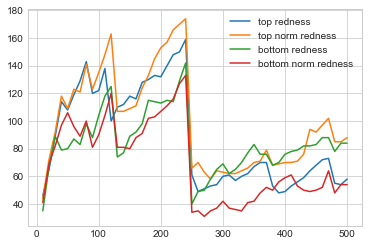

In [30]:
# Import plotting stuff:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Axis:
fig = plt.figure()
ax = plt.axes()

# Data:
line1 = ax.plot([row[0] for row in nsig], [row[1] for row in nsig], label='top redness')
line2 = ax.plot([row[0] for row in nsig], [row[2] for row in nsig], label='top norm redness')
line3 = ax.plot([row[0] for row in nsig], [row[3] for row in nsig], label='bottom redness')
line4 = ax.plot([row[0] for row in nsig], [row[4] for row in nsig], label='bottom norm redness')
ax.legend();